# SPAN extent of required manual markup analysis

Reviewer 1 says:
“The authors developed the SCAN [sic!] methodology which identifies peaks for ULI-ChIP-seq data using semi-supervised approach which uses user-annotations to train a model and choose parameters optimized for minimization of the training error. However, I could not find in the text the extent of manual annotations that should be done in order to achieve a reliable model. In addition, the test-error (manual vs. automated peaks annotation) is not reported. I thus suggest adding a table/plot summarizing the test error resulting from each extent of manual annotation.”

Experiment design: 
* take ABF ChIP-seq data (5 targets, 40 donors)
* investigate the effects of using k = 10, 20, 50, 100 (out of ~500) labels
* for each k, create 10 random batches of k training labels and 500-k test labels (only 5 batches for k=100 for obvious reasons)
* for each batch, tune Span on training labels and report training and test error average the errors across batches
* in total, 7000 = 35 * 5 * 40 training-test error pairs were reported
* from those, 800 = 4 * 5 * 40 mean training-test error pairs were generated

Slides: https://docs.google.com/presentation/d/1iRRPRe6XOqB85rsRHVJ8mNgLGcTV5EiXCapDh1a9g5w/edit?usp=sharing

In [2]:
import pandas as pd;
import numpy as np;
import os;
import matplotlib.pyplot as plt;

In [3]:
TARGETS = ["H3K27ac", "H3K27me3", "H3K4me3", "H3K4me1", "H3K36me3"]
TSVS = [os.path.join("/mnt/stripe/bio/experiments/span-test-error", target + ".tsv") for target in TARGETS]

In [4]:
dataframes = [pd.read_csv(tsv, sep="\t", comment="#") for tsv in TSVS]

In [5]:
for dataframe in dataframes:
    track_id = [i // 35 for i in range(0, len(dataframe))]
    dataframe["track_id"] = track_id

In [6]:
def aggregate_test_error(dataframe):
    res = pd.DataFrame(columns=["k", "track_id", "mean_train_error", "mean_test_error", "sd_train_error", "sd_test_error"])
    for k in sorted(set(dataframe["k"])):
        for track_id in sorted(set(dataframe["track_id"])):
            subset = dataframe[np.logical_and(dataframe["k"] == k, dataframe["track_id"] == track_id)]
            mean_train_error = np.mean(subset["train_error"])
            sd_train_error = np.std(subset["train_error"])
            mean_test_error = np.mean(subset["test_error"])
            sd_test_error = np.std(subset["test_error"])
            res.loc[len(res)] = (k, track_id, mean_train_error, mean_test_error, sd_train_error, sd_test_error)
    return res

In [7]:
test_error_dfs = [aggregate_test_error(dataframe) for dataframe in dataframes]

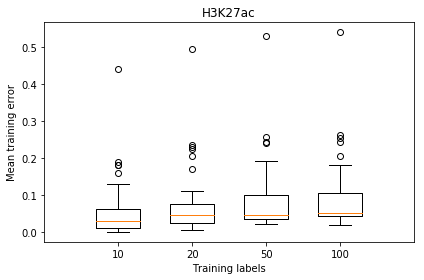

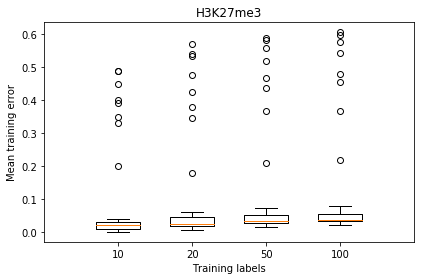

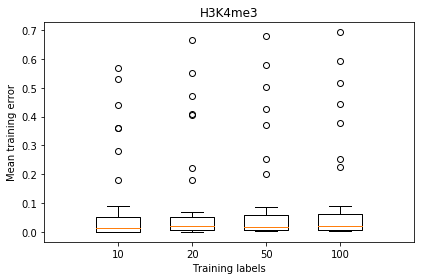

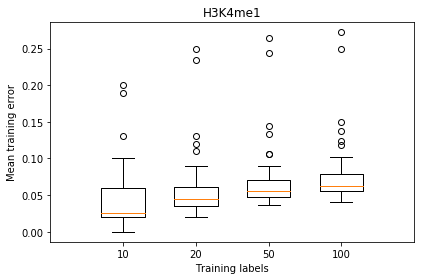

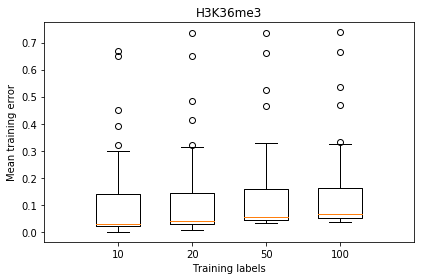

In [21]:
for target, test_error_df in zip(TARGETS, test_error_dfs):
    ks = sorted(set(int(k) for k in test_error_df["k"]))
    for i, k in zip(range(len(ks)), ks):
        data = test_error_df[test_error_df["k"] == k]["mean_train_error"]
        plt.boxplot(data, positions=[i], widths=0.6)
    plt.xlim(-1, len(ks))    
    plt.xticks(range(0,4), ks)
    plt.title(target)
    plt.xlabel('Training labels')
    plt.ylabel('Mean training error')
    plt.tight_layout()
    plt.savefig("{}_train.png".format(target), width=800, height=600)
    plt.show()

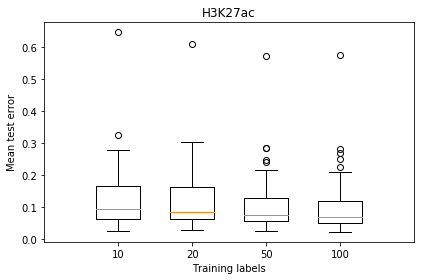

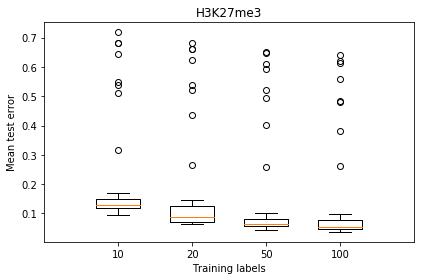

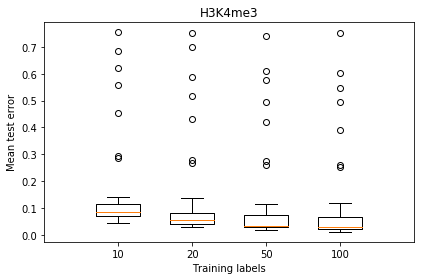

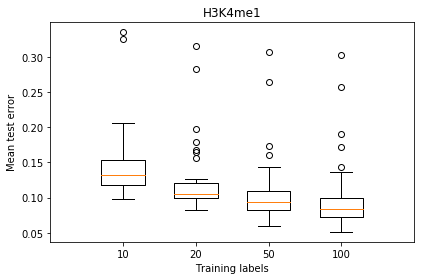

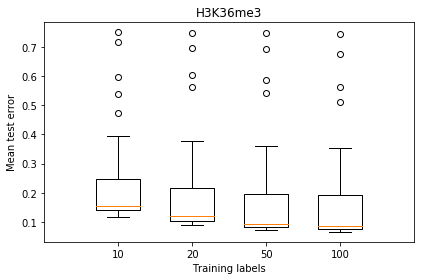

In [22]:
for target, test_error_df in zip(TARGETS, test_error_dfs):
    ks = sorted(set(int(k) for k in test_error_df["k"]))
    for i, k in zip(range(len(ks)), ks):
        data = test_error_df[test_error_df["k"] == k]["mean_test_error"]        
        plt.boxplot(data, positions=[i], widths=0.6)
    plt.xlim(-1,4)    
    plt.xticks(range(0,4), ks)
    plt.title(target)
    plt.xlabel('Training labels')
    plt.ylabel('Mean test error')
    plt.tight_layout()
    plt.savefig("{}_test.png".format(target), width=800, height=600)
    plt.show()

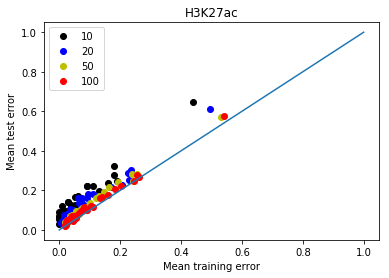

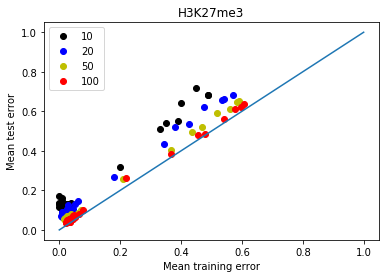

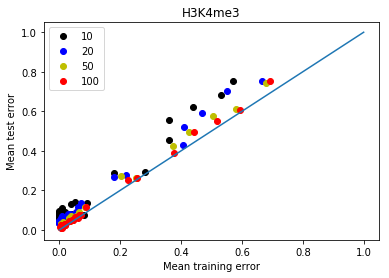

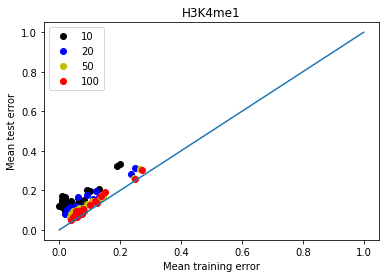

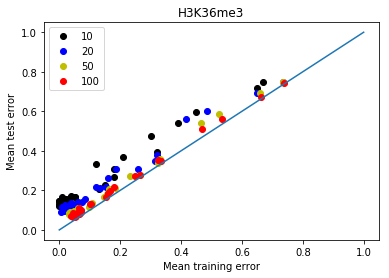

In [23]:
COLOR_MAP = {10: 'k', 20: 'b', 50: 'y', 100: 'r'}
for target, test_error_df in zip(TARGETS, test_error_dfs):
    ks = sorted(set(int(k) for k in test_error_df["k"]))
    for k in ks:
        data = test_error_df[test_error_df["k"] == k]
        plt.plot(data["mean_train_error"], data["mean_test_error"], 'o', color=COLOR_MAP[k])
    plt.xlabel("Mean training error")
    plt.ylabel("Mean test error")
    plt.title(target)    
    # plt.axis([0, 1, 0, 1])
    plt.plot([0,1], [0,1], '-')
    plt.legend(ks)
    plt.savefig("{}_train_test.png".format(target), width=800, height=600)
    plt.show()

In [24]:
mean_sd_errors = pd.DataFrame(columns=["target", "k", "mean_train_error", "sd_train_error", "mean_test_error", "sd_test_error", "test/train", "test - train"])
for target, dataframe in zip(TARGETS, dataframes):
    ks = sorted(set(int(k) for k in dataframe["k"]))
    for k in ks:
        subset = dataframe[dataframe["k"] == k]
        mean_train_error = np.mean(subset["train_error"])
        sd_train_error = np.std(subset["train_error"])
        mean_test_error = np.mean(subset["test_error"])
        sd_test_error = np.std(subset["test_error"])
        mean_sd_errors.loc[len(mean_sd_errors)] = (target, k, mean_train_error, sd_train_error, mean_test_error, sd_test_error, mean_test_error / mean_train_error, (mean_test_error - mean_train_error) * 100)
display(mean_sd_errors)

,target,k,mean_train_error,sd_train_error,mean_test_error,sd_test_error,test/train,test - train
0,H3K27ac,10,0.058000,0.101912,0.132291,0.117872,2.280876,7.429082
1,H3K27ac,20,0.074250,0.102406,0.122745,0.108175,1.653129,4.849479
2,H3K27ac,50,0.086650,0.100453,0.113050,0.102157,1.304674,2.640000
3,H3K27ac,100,0.092000,0.099292,0.109400,0.101031,1.189130,1.740000
4,H3K27me3,10,0.089750,0.166192,0.214474,0.201164,2.389688,12.472449
5,H3K27me3,20,0.106000,0.176993,0.177047,0.200106,1.670254,7.104687
6,H3K27me3,50,0.119400,0.184926,0.154650,0.194108,1.295226,3.525000
7,H3K27me3,100,0.126000,0.187446,0.144162,0.189643,1.144147,1.816250
8,H3K4me3,10,0.084000,0.164146,0.158439,0.192330,1.886176,7.443878
9,H3K4me3,20,0.088250,0.170622,0.135083,0.191058,1.530689,4.683333
